## Objective
Build up to an architecture that can predict digits with 99.4% or higher accuracy (on test set) in 3 stages.

This notebook refers to the **3nd of the 3 stages**, where the refined model architecture is used to meet the specification of the task (model parameters, Dropout, BN). Further Learning Rate Schedulers were used to start the learning faster (with higher initial LR) to quickly find the region of global minima and then reduce the Learning Rate, so that it converges to the minima around that region, thus avoiding falling into the trap of local minima. Augmentation methods such as Rotation ($\pm6.9^\circ$) was also used to help the model generalize better

<br>

---

**Target**
- Use the refined model (without any changes)
- Add Augmentation methods so it generalizes better
    - Rotation of $\pm6.9^\circ$ was used
- Use LR Scheduler to regulate the learning rate during training
- Get the model consistantly over 99.4% accuracy on test set

**Results**
- Best Training Accuracy: _99.17_ (Iteration 14)
- Best Test Accuracy: _99.48_ (Iteration 14)
    - Consistantly over 99.4 from Iteration 10
- Model Parameters: _7,940_

**Analysis**
- Learning Rate Schedulers were used to start the learning faster (with higher initial LR) to quickly find the region of global minima and then reduce the Learning Rate, so that it converges to the minima around that region, thus avoiding falling into the trap of local minima.
- Training accuracy is still not as high as possible; there's still room for improving the results further
---

## Imports

In [1]:
# PyTorch, everything from PyTorch can be referred with this
import torch

# Import the neural network model seperately
import torch.nn as nn

# Contains functions that are required such as ReLu (Activation function)
import torch.nn.functional as F 

# Optimizers required to converge using Backpropogation
import torch.optim as optim

# Datasets are used to download and load the data
# used to train and validate
# Transforms can be used to define modifications and/or augmentations methods
# to be applied while passing the data
# Normalization can also be one of the compositions of transforms
import torchvision
from torchvision import datasets, transforms

# Dataset abstract class using which custom dataset classes can be created
# DataLoader to create batches and to shuffle the data
from torch.utils.data import Dataset, DataLoader

# Visualize the images
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid # ImageGrid to form a grid of images

# Utils
import cv2
import numpy as np
import seaborn as sns
from collections import OrderedDict

In [2]:
# Disable warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

## Create a custom dataset class
Define a class a that loads and takes the images from MNIST to use as input along with the actual label of the handwritten digit which constitutes the required output

In [3]:
class MNISTDataset (Dataset):
    ''' Extending the Dataset class to provide customized inputs and modified 
    outputs for training '''

    def __init__(self, mode='training', additional_transforms=None):
        ''' Get/Download the data (MNIST) and setup up other configurations
        required to get the data
        
        Parameters:
            mode - Indicates either 'training' or 'validation'
            transforms - A list of additional transformations to be added while training
                            By default Normalized the dataset
        '''

        # Start by initializing the base class
        super().__init__()

        # Save the mode
        # Check if the mode is valid
        assert mode in ['training', 'validation'], \
            '"mode" should be either "training" or "validation"'
        self.mode = mode

        # Seed the random generator to results that are reproduceable
        # Remove during production
        torch.manual_seed (1)

        # Define the transformations
        #   First convert into a tensor and then normalization
        #   Values for normalization where got from 
        #   https://discuss.pytorch.org/t/normalization-in-the-mnist-example/457

        # Define a list of transforms to chain together            
        # Both the train and validation transforms are the same, but might decide 
        # to update with some data augmentation methods for train later
        # so keeping it seperate
        self.transforms = [
            transforms.ToTensor (), 
            transforms.Normalize((0.1307,), (0.3081,))]

        # Get MNIST data
        if self.mode == 'training':        

            # Chain the transforms
            if additional_transforms:
                self.transforms = self.transforms+additional_transforms 
        
            # Download the training set and store it at the root directory
            self.data = datasets.MNIST (
                root='./data/train/',
                train=True,
                download=True,
                transform=transforms.Compose (self.transforms))
            
        elif self.mode == 'validation':

            # Get the validation set
            self.data = datasets.MNIST (
                root='./data/val/',
                train=False,
                download=True,
                transform=transforms.Compose (self.transforms))
        

    def __len__(self):
        ''' Get the total size of the dataset '''
        return len (self.data)


    def __getitem__(self, index):
        ''' Used to get the index-th item from the dataset 
        
        Parameters:
            index - Element value to retrieve from the data
        '''

        # Check if the within the bounds of the data
        assert index < len (self.data), 'The index value is out-of-bound'

        # Index into the data to get the image and the corresponding label
        img, label = self.data [index]

        # Return the training set and the corresponding label
        return img, label

### Load the data
Define the data loaders for train and test with $batch\_size = 128$.

In [7]:
# Seed the random generator used by PyTorch
# so that the results are reproduceable
torch.manual_seed(1)

# Define the batch size to be used
# i.e. the number of images to be used per batch
batch_size = 128

# Set it to use GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Define a dataloader 
# Set the batch_size and shuffle to select
# random images for every batch and epoch

# Parameters to be used while loading the data
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

# Additional transformations/augmentations are not added to this
# version, will add that in the next steps
train_loader = DataLoader (
    MNISTDataset (
        mode='training',
        additional_transforms=[
            transforms.RandomRotation (6.9),
            #RandomErosion ((2, 2)),
            #RandomDilation ((2, 2))
        ]),
    batch_size=batch_size,
    shuffle=True,
    **kwargs)

test_loader = DataLoader (
    MNISTDataset (mode='validation'),
    batch_size=batch_size,
    shuffle=True,
    **kwargs)

Using downloaded and verified file: ./data/val/MNIST/raw/train-images-idx3-ubyte.gz
Extracting ./data/val/MNIST/raw/train-images-idx3-ubyte.gz to ./data/val/MNIST/raw

Using downloaded and verified file: ./data/val/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting ./data/val/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/val/MNIST/raw




Extracting ./data/val/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/val/MNIST/raw




Extracting ./data/val/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/val/MNIST/raw



In [8]:
print (f'No. of training batches: {len (train_loader)}\nNo. of test batches: {len (test_loader)}')

No. of training batches: 469
No. of test batches: 79


## Define the network architecture

In [12]:
class MNISTNet(nn.Module):
    ''' Define a class initializing the layers constituting the required 
    CNN Architecture and the code for forward pass
    Note: The class extends to the nn.Module, which is a base class for 
    Neural Network modules in PyTorch https://pytorch.org/docs/stable/generated/torch.nn.Module.html
    '''

    def __init__(self, drop_perc=0.05):
        ''' Define the layers that constitute the network and
        initialize the base class '''

        # Start by initializing the base class
        super().__init__()

        # Store the dropout percentage
        self.drop_perc = drop_perc
    
        # Define the layers that make up the network
        # i.e. the Network Architecture
        # nn.Conv2d - Used to perform 2-dimensional convolution using the defined size of the kernel
        # nn.MaxPool2d - 2d MaxPooling Layer of the defined size

        # MNIST contains images of size 28x28
        # Since the images are padded, the resultant images after convolution
        # would have the same size
        
        # Input Block
        self.input_block = nn.Sequential (
            OrderedDict ([
                ('input_block_conv1', nn.Conv2d (1, 16, 3, padding=0, bias=False)),
                ('input_block_bn', nn.BatchNorm2d (16)),
                ('input_block_relu', nn.ReLU ()),
                ('input_block_dropout', nn.Dropout (self.drop_perc)), # Out: 26
                ('input_block_one', nn.Conv2d (16, 8, 1, padding=0, bias=False)) # Out: 26
            ])
        )

        # First Convolution Block
        self.block1 = nn.Sequential (
            OrderedDict ([
                ('block1_conv1', nn.Conv2d (8, 8, 3, padding=0, bias=False)),
                ('block1_bn1', nn.BatchNorm2d (8)),
                ('block1_relu1', nn.ReLU ()),
                ('block1_dropout1', nn.Dropout (self.drop_perc)), # Out: 24

                ('block1_conv2', nn.Conv2d (8, 16, 3, padding=1, bias=False)),
                ('block1_bn2', nn.BatchNorm2d (16)),
                ('block1_relu2', nn.ReLU ()),
                ('block1_dropout2', nn.Dropout (self.drop_perc)), # Out: 24    
            ])    
        )

        # Pooling Layer
        self.pool_block1 = nn.Sequential (
            OrderedDict ([
                ('pool_b1_mp', nn.MaxPool2d (2, 2)), # Out: 12
                ('pool_b1_one', nn.Conv2d (16, 8, 1, padding=0, bias=False)) # Out: 12
            ])
        )

        # Second Convolution Block
        self.block2 = nn.Sequential (
            OrderedDict ([
                ('block2_conv1', nn.Conv2d (8, 8, 3, padding=0, bias=False)),
                ('block2_bn1', nn.BatchNorm2d (8)),
                ('block2_relu1', nn.ReLU ()),
                ('block2_dropout1', nn.Dropout (self.drop_perc)), # Out: 10

                ('block2_conv2', nn.Conv2d (8, 14, 3, padding=1, bias=False)),
                ('block2_bn2', nn.BatchNorm2d (14)),
                ('block2_relu2', nn.ReLU ()),
                ('block2_dropout2', nn.Dropout (self.drop_perc)), # Out: 10     
                ('block2_one', nn.Conv2d (14, 8, 1, padding=0, bias=False)) # Out: 10
            ])    
        )

        # Last Convolution Block
        self.block3 = nn.Sequential (
            OrderedDict ([
                ('block3_conv1', nn.Conv2d (8, 16, 3, padding=0, bias=False)),
                ('block3_bn1', nn.BatchNorm2d (16)),
                ('block3_relu1', nn.ReLU ()),
                ('block3_dropout1', nn.Dropout (self.drop_perc)), # Out: 8

                ('block3_conv2', nn.Conv2d (16, 18, 3, padding=0, bias=False)),
                ('block3_bn2', nn.BatchNorm2d (18)),
                ('block3_relu2', nn.ReLU ()),
                ('block3_dropout2', nn.Dropout (self.drop_perc)), # Out: 6   
            ])
        )

        # Gap & Final layer with the predictions
        self.prediction = nn.Sequential (
            OrderedDict ([
                ('gap', nn.AvgPool2d (kernel_size=6)),
                ('pred_layer', nn.Conv2d (18, 10, 1, padding=0, bias=False))
            ])
        )

        
    def forward(self, x):
        ''' Define the forward pass
        Each convolution layer is activated using ReLU to add non-linearity
        '''
        # Start with the input block to convert the grayscale (no. of channels = 1)
        # to something higher
        x = self.input_block (x)

        # Convolution layer followed by ReLU Activation, followed by Batch Normalization
        # followed by Dropout and then finally a pooling layer
        # Block 1
        x = self.block1 (x)

        # Pooling layer
        x = self.pool_block1 (x)

        # Block 2
        x = self.block2 (x)

        # Block 3
        x = self.block3 (x)

        # The final layer shouldn't be passed through ReLU, but should be retained
        # Using Global Average Pooling & and 1x1 to reduce the final output size
        x = self.prediction (x)

        # Reshape to fit the output and return
        x = x.view (-1, 10)
        return F.log_softmax (x)

In [13]:
# To display an overview/summary of the network
# Is also useful to validate whether the structure of the network is 
# correct, i.e. the input channels and the output channels and its flow
!pip install torchsummary
from torchsummary import summary

# Set it to use GPU if available
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

# Define the dropout_percentage
dropout_percentage = 0.05

# Create a model object
model = MNISTNet (drop_perc=dropout_percentage).to (device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5            [-1, 8, 26, 26]             128
            Conv2d-6            [-1, 8, 24, 24]             576
       BatchNorm2d-7            [-1, 8, 24, 24]              16
              ReLU-8            [-1, 8, 24, 24]               0
           Dropout-9            [-1, 8, 24, 24]               0
           Conv2d-10           [-1, 16, 24, 24]           1,152
      BatchNorm2d-11           [-1, 16, 24, 24]              32
             ReLU-12           [-1, 16, 24, 24]               0
          Dropout-13           [-1, 16, 24, 24]               0
        MaxPool2d-14           [-1, 16,

## Train and Validate

In [14]:
# TQDM is just awesome... provides a progress status bar as the training 
# (or any operation) proceeds
from tqdm import tqdm


def train(model, device, train_loader, optimizer, epoch, scheduler=None):
    ''' Define the training steps '''

    # Set the model to training mode
    model.train()
    
    # Initialize the counters
    correct = 0
    processed = 0

    # Initialize the progress bar
    pbar = tqdm(train_loader)

    # Start iterating through the training data
    for batch_idx, (data, target) in enumerate(pbar):
        # Start by converting the data to the required type 
        # (PyTorch Cuda Tensor while using GPU)
        data, target = data.to(device), target.to(device)

        # Discard/reset the gradients from the last iteration
        optimizer.zero_grad()

        # Get the predictions for the given data
        output = model(data)

        # Compute the negative loss likelihood of the predictions vs the actuals
        # and propogate the loss backwards (back propogation)
        loss = F.nll_loss(output, target)
        loss.backward()

        # Use the optimizer to take a step in the -ve of the gradient direction
        # by the amount equal to the gradient magnitude times the learning rate 
        optimizer.step()
        
        # Get the index of the prediction
        # i.e. the output is one-hot encoded, so get the argument with the max
        # log probability
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

        # Get a count of the correct preditcions
        correct += pred.eq(target.view_as(pred)).sum().item()
        
        # Update the no of records processed
        processed += len (data)

        # Update the progress bar
        pbar.set_description(
            desc=f'Loss={loss.item():.4f}; '+\
                 f'Accuracy={correct*100/processed:.2f}; '+\
                 f'Learning Rate={optimizer.param_groups[0]["lr"]:.4f}')
        
        # Store the training accuracy & loss
        training_accuracy.append (correct*100/processed)
        training_losses.append (loss)

    # Update the learning rate after each training cycle
    if scheduler:
        scheduler.step ()


def test(model, device, test_loader):
    ''' Validate the trained model on a hold-out set '''

    # Set the model to evalution mode
    model.eval()
    
    # Initialize the losses
    # and the no of correct predictions to 0
    test_loss = 0
    correct = 0

    # Disable the gradient computations
    # While evaulating only forward pass is used and the backward pass
    # along with the gradient (likewise the gradient update) isn't required
    with torch.no_grad():
        # Iterate over the test/validation set
        for data, target in test_loader:
            # Converting the data to the required type 
            # (PyTorch Cuda Tensor while using GPU)
            data, target = data.to(device), target.to(device)

            # Get the predictions
            output = model(data)

            # Compute the loss against the target
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            # Get the index of the prediction
            # i.e. the output is one-hot encoded, so get the argument with the max
            # log probability
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            # Get a count of the correct preditcions
            correct += pred.eq(target.view_as(pred)).sum().item()

    # Compute the final loss on the test/validation data
    test_loss /= len(test_loader.dataset)

    # Display the results
    print('\nTest set: Loss={:.4f}; Accuracy={}/{} ({:.2f}%)\n\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Store the training accuracy & loss
    test_accuracy.append (correct*100/len(test_loader.dataset))
    test_losses.append (test_loss)

    # Return the test accuracy and loss
    # Update LR based on this
    return test_accuracy [-1], test_losses [-1]

In [19]:
# Initialize the model instance
model = MNISTNet().to(device)

# Define an optimizer to use to perform gradient descent
# Various optimizers are suitable for different usecase, which help
# reach the global optimal (i.e. a model with least errors/loss) quickly
# In this case, Stochastic Gradient Descent (SGD) is used with momentum of 0.9
# and the learning rate (alpha) set to 0.01 

# Have the learning rate initially so that it gets to the region of the global minima
# faster and then reduce it so the it converges slowly to the required minima
# This should avoid falling into local minima
optimizer = optim.SGD (model.parameters(), lr=0.06, momentum=0.9)

# Define a learning rate scheduler
# Refered from: https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling
# and https://pytorch.org/docs/master/optim.html
# https://pytorch.org/docs/master/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html#torch.optim.lr_scheduler.ReduceLROnPlateau
# Decrease the learning rate after a particular step
plat_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', 
    factor=0.05, patience=2, 
    min_lr=0.0001, threshold=0.001, 
    verbose=True)

# Reduce the Learning Rate at the specified iteration
# Choose this is based on the previous runs
multistep_scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[5, 7, 12], 
    gamma=0.5, verbose=True)

# Train the model for n epochs
epochs = 14

# Store the training accuracy and losses
training_accuracy = []
training_losses = []

# Store the test accuracy and losses
test_accuracy = []
test_losses = []

for epoch in range(0, epochs):
    print (f'Iteration {epoch+1}')
    # Initiate training phase
    train(model, device, train_loader, optimizer, epoch, multistep_scheduler)

    # Validate the results on the test/validation set
    accuracy, loss = test(model, device, test_loader)

    # Reduce the learning rate if the loss has plateaued
    plat_scheduler.step (loss)

print (f'Best Model had a Training Accuracy of {np.max (training_accuracy):.2f}', 
        f'& a Test Accuracy of {np.max (test_accuracy):.2f}')

  0%|          | 0/469 [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 6.0000e-02.
Iteration 1


Loss=0.1068; Accuracy=90.25; Learning Rate=0.0600: 100%|██████████| 469/469 [00:32<00:00, 14.63it/s]

Adjusting learning rate of group 0 to 6.0000e-02.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0700; Accuracy=9781/10000 (97.81%)


Iteration 2


Loss=0.1812; Accuracy=97.68; Learning Rate=0.0600: 100%|██████████| 469/469 [00:31<00:00, 14.69it/s]

Adjusting learning rate of group 0 to 6.0000e-02.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0533; Accuracy=9845/10000 (98.45%)


Iteration 3


Loss=0.1714; Accuracy=97.91; Learning Rate=0.0600: 100%|██████████| 469/469 [00:31<00:00, 14.78it/s]

Adjusting learning rate of group 0 to 6.0000e-02.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0312; Accuracy=9908/10000 (99.08%)


Iteration 4


Loss=0.0735; Accuracy=98.33; Learning Rate=0.0600: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

Adjusting learning rate of group 0 to 6.0000e-02.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0274; Accuracy=9916/10000 (99.16%)


Iteration 5


Loss=0.0749; Accuracy=98.39; Learning Rate=0.0600: 100%|██████████| 469/469 [00:31<00:00, 14.77it/s]

Adjusting learning rate of group 0 to 3.0000e-02.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0416; Accuracy=9865/10000 (98.65%)


Iteration 6


Loss=0.0052; Accuracy=98.74; Learning Rate=0.0300: 100%|██████████| 469/469 [00:31<00:00, 14.74it/s]

Adjusting learning rate of group 0 to 3.0000e-02.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0262; Accuracy=9914/10000 (99.14%)


Iteration 7


Loss=0.0091; Accuracy=98.80; Learning Rate=0.0300: 100%|██████████| 469/469 [00:31<00:00, 14.66it/s]

Adjusting learning rate of group 0 to 1.5000e-02.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0230; Accuracy=9929/10000 (99.29%)


Iteration 8


Loss=0.0449; Accuracy=98.92; Learning Rate=0.0150: 100%|██████████| 469/469 [00:32<00:00, 14.64it/s]

Adjusting learning rate of group 0 to 1.5000e-02.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0194; Accuracy=9943/10000 (99.43%)


Iteration 9


Loss=0.0649; Accuracy=99.06; Learning Rate=0.0150: 100%|██████████| 469/469 [00:31<00:00, 14.70it/s]

Adjusting learning rate of group 0 to 1.5000e-02.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0192; Accuracy=9937/10000 (99.37%)


Iteration 10


Loss=0.0348; Accuracy=99.04; Learning Rate=0.0150: 100%|██████████| 469/469 [00:32<00:00, 14.61it/s]

Adjusting learning rate of group 0 to 1.5000e-02.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0174; Accuracy=9945/10000 (99.45%)


Iteration 11


Loss=0.0472; Accuracy=99.04; Learning Rate=0.0150: 100%|██████████| 469/469 [00:31<00:00, 14.81it/s]

Adjusting learning rate of group 0 to 1.5000e-02.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0187; Accuracy=9947/10000 (99.47%)


Iteration 12


Loss=0.0301; Accuracy=98.97; Learning Rate=0.0150: 100%|██████████| 469/469 [00:31<00:00, 14.71it/s]

Adjusting learning rate of group 0 to 7.5000e-03.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0180; Accuracy=9947/10000 (99.47%)


Iteration 13


Loss=0.0233; Accuracy=99.10; Learning Rate=0.0075: 100%|██████████| 469/469 [00:31<00:00, 14.68it/s]

Adjusting learning rate of group 0 to 7.5000e-03.



  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Loss=0.0182; Accuracy=9947/10000 (99.47%)


Epoch    13: reducing learning rate of group 0 to 3.7500e-04.
Iteration 14


Loss=0.0184; Accuracy=99.17; Learning Rate=0.0004: 100%|██████████| 469/469 [00:31<00:00, 14.71it/s]

Adjusting learning rate of group 0 to 3.7500e-04.



Test set: Loss=0.0172; Accuracy=9948/10000 (99.48%)


Best Model had a Training Accuracy of 100.00 & a Test Accuracy of 99.48


### Plot the accuracy and loss

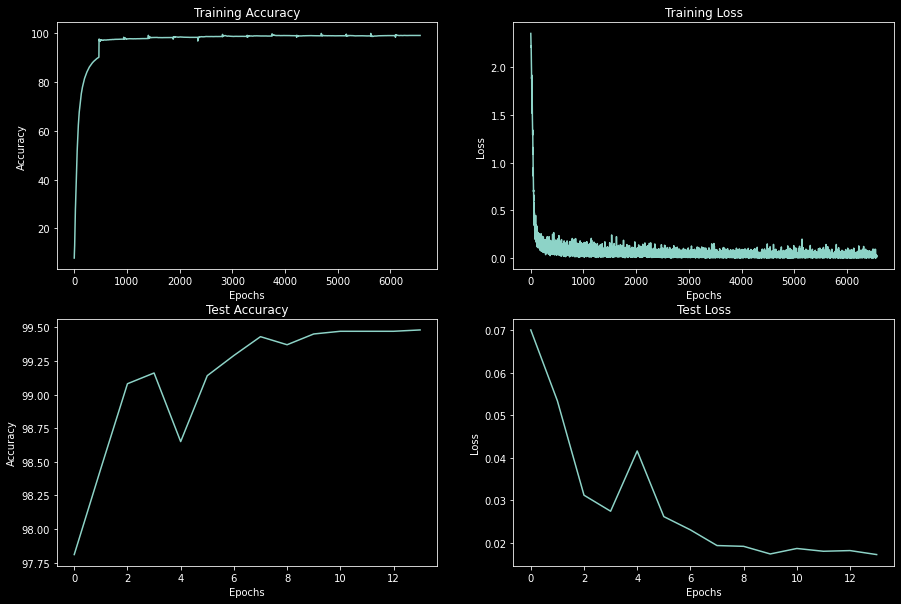

In [20]:
plt.style.use ('dark_background') # Dark mode rocks!!!

# Define the size of the figure
plt.figure (figsize=(15, 10))

# Plot the Training Accuracy
plt.subplot (221)
plt.plot (training_accuracy)
plt.title ('Training Accuracy')
plt.ylabel ('Accuracy'); plt.xlabel ('Epochs');

# Losses during training
plt.subplot (222)
plt.plot (training_losses)
plt.title ('Training Loss')
plt.ylabel ('Loss'); plt.xlabel ('Epochs');

# Test Accuracy at each epoch
plt.subplot (223)
plt.plot (test_accuracy)
plt.title ('Test Accuracy')
plt.ylabel ('Accuracy'); plt.xlabel ('Epochs');

# Test Losses at each epoch
plt.subplot (224)
plt.plot (test_losses)
plt.title ('Test Loss')
plt.ylabel ('Loss'); plt.xlabel ('Epochs');

- Training accuracy is still not as high as possible; there's still room for improving the results further